**IE0005 Mini-Project: Online Fake Job Detection with NLP Approach**

**Team Koviema:**

1. SEO JUNEYOUNG
2. YOO JAE WON
3. NGUYEN TUAN ANH

***This project's objective*** is to anticipate job advertisements that are fake by doing a comparative examination of four distinct classification models. In this research, an automated solution using machine learning-based classification approaches is presented to prevent fraudulent job postings on the internet. A variety of supervised learning techniques are utilized, including XGBoost, Support Vector Machine, Logistic Regression, and Random Forest. And the best algorithm is chosen by taking into account the various factors. To forecast the effective algorithm, accuracy score, confusion matrix, and classification report are evaluted

Our dataset is available on Kaggle: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import important libraries and modules**

In [ ]:
# Importing all required libraries
import numpy as np
import pandas as pd
import re
import string
import numpy as np
import pandas as pd
import random
import missingno
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Import libraries related to models and vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,roc_auc_score
from sklearn.model_selection import train_test_split
from string import punctuation
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Importing natural languge processing libraries
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm

# **Initial overview of the data**

In [ ]:
# Specify the File Path
file_path = 'fake_job_postings.csv'

# Load File 
data = pd.read_csv(file_path) 

# A quick view
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


This plot shows the rate of fake and real job postings in the dataset. The data is highly imbalaced

# **EDA (Exploratory Data Analysis)**

Visualizing the completeness of the data help us determine which data will not be very useful to be a variable to classify fradulent data. We can fliter it out.

We can conclude that the data in the 'department' , 'salary_range' and 'required_education' column has a lot of null datas which are not usefull in predicting fake jobs.

In [ ]:
# Fill the blank spaces in the location column
data.location = data.location.fillna('blank')

In [ ]:
# Assign data to data_US column
data_US=data

In [ ]:
# Splitting the locations in the location column into two new columns state and city
loc_split =[]
for loc in data_US.location:
    loc_split.append(loc.split(','))

loc_split = pd.DataFrame(loc_split)

loc_split = loc_split[[1, 2]]

loc_split = loc_split.rename(columns={1: "state", 2:'city'})

In [ ]:
# Reseting the index of the dataframe
data_US = data_US.reset_index()

Apply new column to the dataset

In [ ]:

# Joining the state and city column into the main dataframe
data_US = data_US.join(loc_split)

In [ ]:
# Reassuring that all columns are available and arranged accordingly
data_US = data_US[['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'state', 'city']]

Selecting only not null instances in city and state column

In [ ]:
# Selecting data will no missing values for the corresponding columns (state and city)
data_US = data_US[data_US['city'].notna()]
data_US = data_US[data_US['state'].notna()]

A new column state_city combining state and city columns

In [ ]:
# Grouping state and city columns to a new column state city
data_US['state_city'] = data_US['state'] + ", " + data_US['city']

Checking for null values

In [ ]:
# Check for null values
data_US.isna().sum()

job_id                     0
title                      0
location                   0
department             11183
salary_range           14631
company_profile         3189
description                1
requirements            2487
benefits                6903
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3240
required_experience     6768
required_education      7790
industry                4635
function                6167
fraudulent                 0
state                      0
city                       0
state_city                 0
dtype: int64

# **Data Pre-pocessing**

All text related columns are stored in one variable text while the individual columns are deleted since they have no more use. These features are selected as they have shown contribution and significance corresponding to target variable. Hence they will be used for prediction

In [ ]:
# combine all columns with text in a new column called "text" and dropping individual columns
data_US['text'] =  data_US['title'] + ' ' + data_US['location'] + ' ' + data_US['company_profile'] + ' ' + \
        data_US['description'] + ' ' + data_US['requirements'] + ' ' + data_US['benefits'] + ' ' + \
        data_US['required_experience'] + ' ' + data_US['required_education'] + ' ' + data_US['industry'] + ' ' + data_US['function']


data_US.drop(['job_id', 'department', 'salary_range', 'title','location','department','company_profile','description','requirements','benefits','employment_type','required_experience','required_education','industry','function', 'city', 'state_city', 'has_company_logo', 'has_questions', 'state'], axis = 1, inplace = True)

In [ ]:
# eliminate all null values
data_US=data_US.dropna()

In [ ]:
# check the remaining instances and attributes
data_US.shape

(4482, 3)

In [ ]:
# view the remaining data
data_US.head()

,telecommuting,fraudulent,text
3,0,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."
6,0,0,"Head of Content (m/f) DE, BE, Berlin Founded i..."
14,0,0,"Account Executive - Sydney AU, NSW, Sydney Adt..."
15,0,0,"VP of Sales - Vault Dragon SG, 01, Singapore J..."


**Character Count Plot**

Overall, the frequency of words in fake jobs are significanly lesser than real jobs.

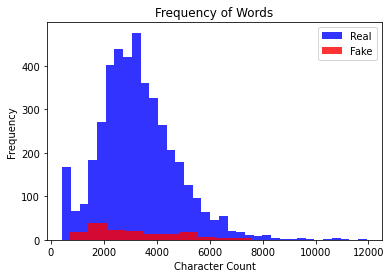

In [ ]:
# check the total number of words for real and fake job postings
data_US['character_count'] = data_US.text.apply(len)

data_US[data_US.fraudulent==0].character_count.plot(bins=35, kind='hist', color='blue', 
                                       label='Real', alpha=0.8)
data_US[data_US.fraudulent==1].character_count.plot(kind='hist', color='red', 
                                       label='Fake', alpha=0.8)
plt.legend()
plt.title('Frequency of Words')
plt.xlabel("Character Count");

In [ ]:
# dropping the character count column
data=data_US
data.drop(['character_count'], axis = 1, inplace = True)
data.drop(['telecommuting'], axis = 1, inplace = True)

In [ ]:
# confirming the remaining data
data.head()

,fraudulent,text
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."
6,0,"Head of Content (m/f) DE, BE, Berlin Founded i..."
14,0,"Account Executive - Sydney AU, NSW, Sydney Adt..."
15,0,"VP of Sales - Vault Dragon SG, 01, Singapore J..."


# **Data Transformation**

Data transform is a mandatory step when we are working with text in Natural Language Processing

**Using NLP (Natural Language Processing)** with following step:

**Sentence Segmentation:** Breaking the phrase into separate Sentences

**Word Tokenization:** Breaking the sentence to separate words

**Stemming:** Transforming the words to their roots

**Lemmatization and Convert To Lower Case:** It produces the root word which has a meaning

**Removing Stop Words:** The words such as 'is', 'and', 'the',... should be filtered out before any statistical analysis

In [ ]:
# Creating list of punctuation marks
punctuations = string.punctuation

# Creating list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Loading the English tokenizer, tagger, parser and word vectors
parser = English()

# Creating the tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing and lowercasing all tokens
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

#     # Removing all stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return list of tokens
    return mytokens

More text cleaning to boost the accuracy and perfomance

In [ ]:
# Customized transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning the Text
        return [clean_text(text) for text in X]
        # declaring the fit function
    def fit(self, X, y=None, **fit_params):
        return self
        # return the paramters obtained
    def get_params(self, deep=True):
        return {}

# function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

TFid Vectorizer is used to convert text into vectors also priortizing the important features

In [ ]:
# Changing words into vectors using tfid vectorizer
bowtf_vector=TfidfVectorizer(analyzer='char',tokenizer = spacy_tokenizer,ngram_range=(1,3))

## **Traning and Predicting**

The data is split into training and testing with 25% data for testing

In [ ]:
# splitting our data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, test_size=0.25)

# Fit to model (Logistic Regression)


Here a pipe is created which combines the cleaning function, tfid vectorizer function and the model.

The data is passed through these functions accordingly.

Hence the data is cleaned then vectorized and then classified

Logistic regression is also used to estimate the relationship between a dependent variable and one or more independent variables, but it is used to make a prediction about a categorical variable versus a continuous one. A categorical variable can be fraudulent or non-fraudulent, 1 or 0

In [ ]:
# logistic regression model
clf = LogisticRegression()

# Create pipeline for all three functions
pipe2 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bowtf_vector),
                 ('classifier', clf)])

# fitting our model.
pipe2.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7a1590a350>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3),
                                 tokenizer=<function spacy_tokenizer at 0x7f7a14fabb90>)),
                ('classifier', LogisticRegression())])

In [ ]:
# testing the model with predict function
predicted = pipe2.predict(X_test)

# checking for Accuracy and recall
lra_score=accuracy_score(y_test, predicted)
print("Logistic Regression Accuracy:", lra_score)
lrr_score=recall_score(y_test, predicted)
print("Logistic Regression Recall:", lrr_score)

Logistic Regression Accuracy: 0.9652096342551294
Logistic Regression Recall: 0.0


# Fit data into model (Support Vector Machine)

In [ ]:
# support vector machine model
clf = SVC()

# Create pipeline for all three functions
pipe3 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bowtf_vector),
                 ('classifier', clf)])

# fitting our model.
pipe3.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7a13db42d0>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3),
                                 tokenizer=<function spacy_tokenizer at 0x7f7a14fabb90>)),
                ('classifier', SVC())])

In [ ]:
# testing the model with predict function
predicted = pipe3.predict(X_test)

# checking for Accuracy and recall
svca_score=accuracy_score(y_test, predicted)
print("SVC Accuracy:", svca_score)
svcr_score=recall_score(y_test, predicted)
print("SVC Recall:", svcr_score)

SVC Accuracy: 0.9652096342551294
SVC Recall: 0.0


# Fit data to model (XGBoost)



XGBoost is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm, which attempts to accurately predict a target variable by combining the estimates of a set of simpler, weaker models.

When using gradient boosting for regression, the weak learners are regression trees, and each regression tree maps an input data point to one of its leafs that contains a continuous score. XGBoost minimizes a regularized (L1 and L2) objective function that combines a convex loss function (based on the difference between the predicted and target outputs) and a penalty term for model complexity (in other words, the regression tree functions). The training proceeds iteratively, adding new trees that predict the residuals or errors of prior trees that are then combined with previous trees to make the final prediction. It's called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

Below is a brief illustration on how gradient tree boosting works.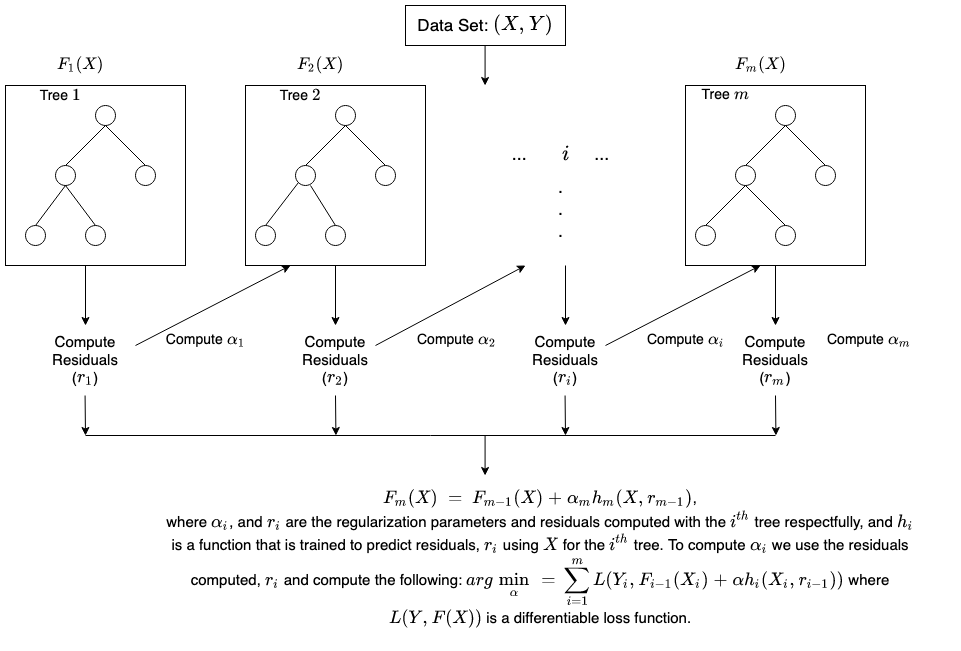

In [ ]:
# XGboost ensemble model
clf = XGBClassifier()

# Create pipeline for all three functions
pipe4 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bowtf_vector),
                 ('classifier', clf)])

# fitting our model.
pipe4.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7a14abb290>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3),
                                 tokenizer=<function spacy_tokenizer at 0x7f7a14fabb90>)),
                ('classifier', XGBClassifier())])

In [ ]:
# testing the model with predict function
predicted1 = pipe4.predict(X_test)

# checking for Accuracy and recall
XGBa_score=accuracy_score(y_test, predicted1)
print("XGBoost Accuracy:", XGBa_score)
XGBr_score=recall_score(y_test, predicted1)
print("XGBoost Recall:", XGBr_score)

XGBoost Accuracy: 0.9928635147190009
XGBoost Recall: 0.7948717948717948


# Fit data to Model (Random Forest)


In [ ]:
# random forest model
clf = RandomForestClassifier()

# Create pipeline for all three functions
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bowtf_vector),
                 ('classifier', clf)])

# fitting our model
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7a16baf550>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3),
                                 tokenizer=<function spacy_tokenizer at 0x7f7a14fabb90>)),
                ('classifier', RandomForestClassifier())])

In [ ]:
# testing the model with predict function
predicted2 = pipe.predict(X_test)

# checking for Accuracy and recall
rfa_score= accuracy_score(y_test, predicted2)
print("Random Forest Accuracy:", rfa_score)
rfr_score=recall_score(y_test, predicted2)
print("Random Forest Recall:", rfr_score)

Random Forest Accuracy: 0.9937555753791257
Random Forest Recall: 0.8205128205128205


# **Comparison of Models**
All the models are compared on basis of accuracy and recall

In [ ]:
# declaring data for model variable (string name and corresponding scores)
models = [('Logistic Regression', lra_score,lrr_score),
          ('SVM', svca_score,svcr_score),
          ('XGBoost', XGBa_score,XGBr_score),
          ('Random Forest', rfa_score,rfr_score),
         ]

In [ ]:
# creating a table based on the variable models
predict = pd.DataFrame(data = models, columns=['Model', 'Accuracy', 'Recall'])
predict

,Model,Accuracy,Recall
0,Logistic Regression,0.965210,0.000000
1,SVM,0.965210,0.000000
2,XGBoost,0.992864,0.794872
3,Random Forest,0.993756,0.820513


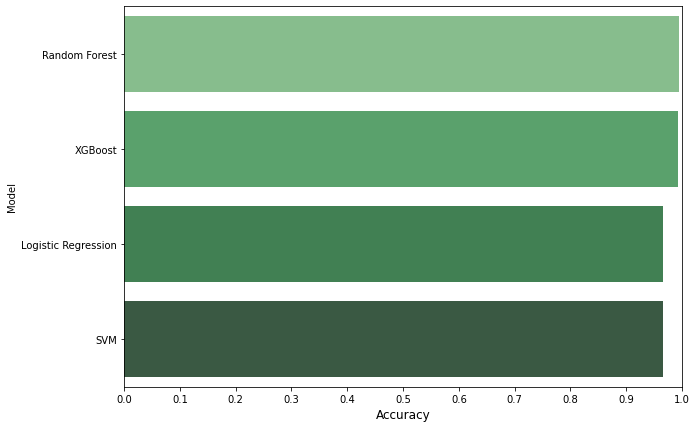

In [ ]:
# checking the model with highest accuracy
predict.sort_values(by=['Accuracy'], ascending=False, inplace=True)

f, axes = plt.subplots(1,figsize=(10,7))

sns.barplot(x='Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes)
axes.set_xlabel('Accuracy', size=12)
axes.set_ylabel('Model')
axes.set_xlim(0,1.0)
axes.set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

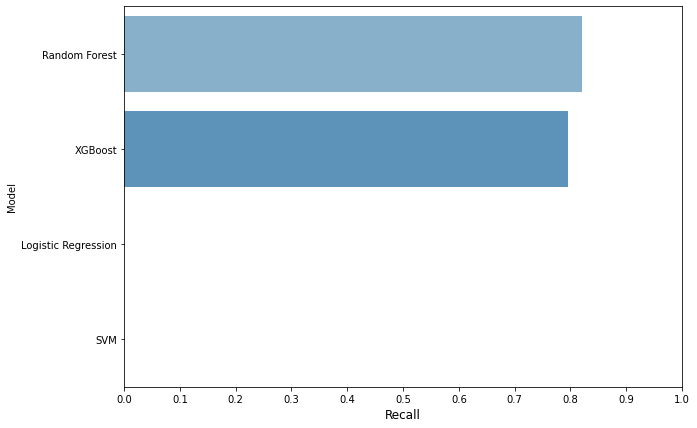

In [ ]:
# checking the model with highest recall
predict.sort_values(by=['Recall'], ascending=False, inplace=True)

f, axes = plt.subplots(1,figsize=(10,7))

sns.barplot(x='Recall', y='Model', data = predict, palette='Blues_d', ax = axes)
axes.set_xlabel('Recall', size=12)
axes.set_ylabel('Model')
axes.set_xlim(0,1.0)
axes.set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

Random Forest also show the highest value of recall which evaluates the model ability to classify wrong and correct values accordingly, following by XGBoost Model.The score is 76%. Other models show zero recall since they failed to identify true positive values

# **Random Forest Evaluation**

In [ ]:
# print a classification report for one of two best model
from sklearn.metrics import classification_report 
print(classification_report(y_test, predicted2))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1082
           1       1.00      0.82      0.90        39

    accuracy                           0.99      1121
   macro avg       1.00      0.91      0.95      1121
weighted avg       0.99      0.99      0.99      1121



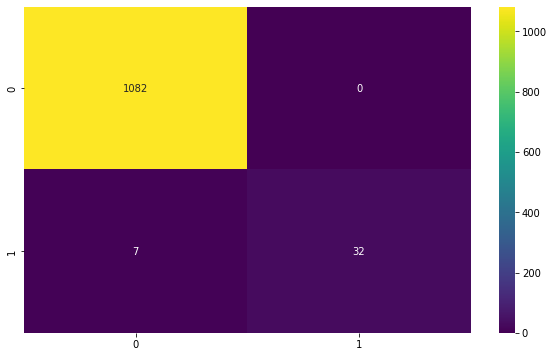

In [ ]:
# building the confusion matrix to check the results
plt.figure(figsize=(10,6))
from sklearn.metrics import confusion_matrix
cm=sns.heatmap(confusion_matrix(y_test, predicted2), annot=True, cmap = 'vi ridis', fmt='.0f')
plt.show()

**Confusion Matrix**

True Positive = ‘1082’ means that 1298 non-fraudulent values are classified correctly by the model.

True Negative = ‘30’ means that 38 fraudulent values are classified correctly by the model.

False Positive = ‘9’ means that 14 non-fraudulent values are classified incorrectly by the model.

False Negative = ‘0’ means that 0 fraudulent values are classified incorrectly by the model.

**ROC Analysis**

The graph shows that the area under graph has value of 88.46% meaning the model did quite well overall.**

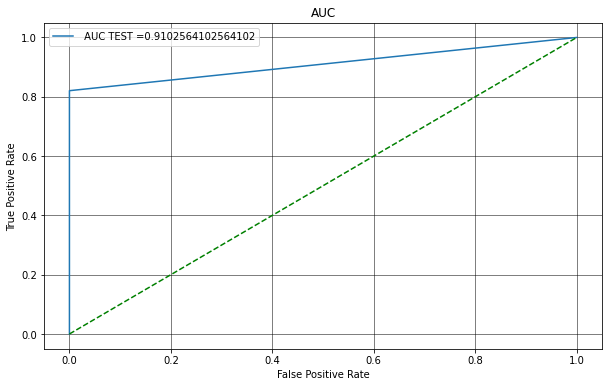

In [ ]:
# building the roc curve to check the results
plt.figure(figsize=(10,6))
from sklearn.metrics import roc_curve, auc
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, predicted2)

plt.grid()

plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)